In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection
import sklearn.metrics
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.feature_selection import mutual_info_regression

import sklego.preprocessing
import fairlearn.preprocessing

from fairness import fairestimator
from fairness.blog import utils

np.random.seed(42)

# Dealing with more complex biases: continuous attributes and non-linear, correlated bias

This notebook is part of a blog series where I investigate bias in AI.

1. [Introducing the IgnoringEstimator](https://github.com/SjoerdCor/fairness/blob/main/blog/1.IntroducingTheIgnoringEstimator.ipynb) introduced measures of fairness and showed how naive approaches do not solve them, and on the other hand how easily the IgnoringEstimator is implemented and solves them well
1. [Dealing with more complex biases](https://github.com/SjoerdCor/fairness/blob/main/blog/2.DealingWithMoreComplexBiases.ipynb) first shows how common complex biases are: non-linear, correlated with other attributes and for continuous features, and shows how easy it is to mitigate the disparate treatment with the `IgnoringBiasEstimator`. I also show how little attention there seems to be for this problem in existing approaches.
1. [Ignoring bias for cassification poblems](https://github.com/SjoerdCor/fairness/blob/main/blog/3.IgnoringBiasForClassificationProblems.ipynb) finally shows how to use the Ignoring Estimator for the classic classification problems - since these are more prolific, we can also compare against a wide variety of existing approaches and see the `IgnoringBiasEstimator` does equally well or better both in terms of bias mitigation and accuracy.


## Many bias mitigation strategies only work for monotonic biases


In the [first notebook](https://github.com/SjoerdCor/fairness/blob/main/IntroducingTheIgnoringEstimator.ipynb), I introduced the IgnoringBiasEstimator, which was shown to work great to remove the disparate treatment between two groups. However, in that example, and in fact in many others concerning AI Fairness, the sensitive attribute was binary (Gender 1 vs Gender 2). In fact, many examples indeed artifically make columns binary, for instance by discretizing based on whether the value is larger or smaller than the mean, median or a custom value (e.g. [aif360](https://nbviewer.jupyter.org/github/Trusted-AI/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb), [scikit-lego](https://scikit-lego.readthedocs.io/en/latest/fairness.html)). 

This is a problem if the biases are not monotonic and/or correlated with other, possibly sensitive attributes. It is easy to imagine a real-world scenario where middle-aged people are privileged over both juniors and seniors, or females between 25 and 35 being disadvantaged because of possible maternity leave.

In this notebook, I'll show two problems with most current approaches:
* Many fail to recognize there is a bias in our algorithm, by oversimplifying the problem
* The choice for approaches for regression is much smaller than for classification
* Even when a strategies are applicable, they often fail to reduce the bias (fully)
* The `IgnoringBiasEstimator` reduces bias fully, for complex biases, also for regression problems, out-of-the-box

To show this, we generate a toy dataset where the salary of an employee depends on education, experience (correlated with age) and social skills, as desired, but also, undesirably, on the age of an employee. Middle-aged employees have higher salaries than younger and older employees

<img src="./figures/DGP_Salary_age.PNG" title="The data generating process for salary for an imaginary company with biases in employee salaries"/>

In [2]:
def generate_employees_age(size=2500):
    X = (pd.DataFrame({'Age': 25 + 40 * np.random.rand(size),
                       'Education': 4 + 16 * np.random.rand(size),
                       'SocialSkills': np.random.rand(size)
                      }
                     )
         .assign(Experience = lambda df: df['Age'].sub(np.random.randint(15, 40, size=size)).clip(0).mul(np.random.rand(size)*2))
        )
    return X

def add_salaries_age(df):
    weights = {'Age': 0,
               'Education': 150,
               'Experience': 20,
               'SocialSkills': 1000
              }
    error = np.random.normal(0, 150, size=len(df))
    df = df.assign(SalarySkill = lambda df: df.mul(weights).sum('columns').add(error),
                   SalaryTrue = lambda df: df['SalarySkill'].sub(utils.generate_bias(df['Age'], effect_size=400, power=2)))
    return df

In [3]:
df = generate_employees_age(5000).pipe(add_salaries_age)
utils.display_df(df)
X_train, X_test, y_train, y_test, y_skill_train, y_skill_test = sklearn.model_selection.train_test_split(df.filter(['Age', 'Education', 'SocialSkills', 'Experience']),
                                                                                                         df['SalaryTrue'],
                                                                                                         df['SalarySkill'])

,Age,Education,SocialSkills,Experience,SalarySkill,SalaryTrue
1501,44.17,5.28,0.88,22.90,€2350.76,€2798.77
2586,27.87,10.68,0.21,0.00,€1729.49,€1210.49
2653,27.09,17.00,0.46,0.00,€3067.69,€2458.15
1055,39.03,11.89,0.35,30.89,€2894.46,€3229.66
705,64.60,8.25,0.59,4.06,€1865.94,€1011.83
106,41.42,9.87,0.26,38.36,€2358.85,€2768.45
589,31.08,14.26,0.14,0.09,€2399.64,€2211.42
2468,44.02,13.83,0.55,1.28,€2824.08,€3271.33
2413,26.10,17.20,0.97,0.00,€3515.90,€2784.77
1600,32.67,12.54,0.39,18.44,€2613.12,€2564.15


We see that the observed salary increases with age until the age of ~45 and then starts to decrease, albeit slower than the increase before 45. This is a combination of experience being larger and larger and the bias that benefits middle-aged people. 

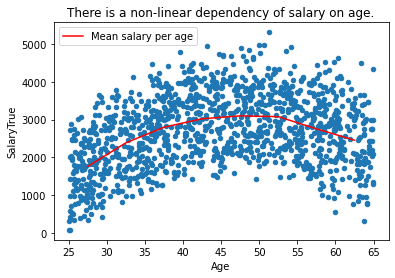

In [4]:
ax = (df
      .sample(frac=0.25)  # Less cluttered visualization
      .plot(kind='scatter', x='Age', y='SalaryTrue', title='There is a non-linear dependency of salary on age.')
     )
(df
 .assign(Age = lambda df: df['Age']//5*5 + 2.5).groupby('Age')['SalaryTrue'].mean()
 .plot(ax=ax, c='r', label='Mean salary per age')
)
plt.legend()
plt.show()

## Failing to recognize the bias: Dividing continous attributes into buckets can hide the bias
First, let's look into the simplest solution, applying no bias mitigation. We train a model on all features, and check whether salaries of people are biased with for people older than the median with respect to people younger than the median. While we used `LinearRegression` in the previous installment, here we switch to a `RandomForestRegressor` because of the non-linear nature.

Discretizing the senstive attribute happens often in examples of respected packages, such as in [the tutorial by `aif360`](https://nbviewer.jupyter.org/github/Trusted-AI/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb) and the [second approach of `sklego`](https://scikit-lego.readthedocs.io/en/latest/fairness.html).



In [5]:
rf_kwargs = {'min_samples_leaf': 2, 'random_state': 42}

In [6]:
rf =  RandomForestRegressor(**rf_kwargs)
rf.fit(X_train, y_train)
y_pred = utils.predict_series(rf, X=X_test)
y_bias = y_pred.sub(y_skill_test).rename('BiasNaive')

In [7]:
biases = pd.concat([X_test['Age'], y_bias], axis='columns')

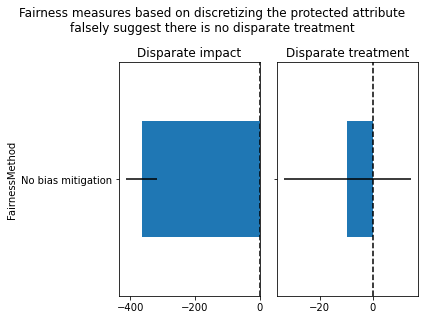

In [8]:
young_old_boundary = X_train['Age'].median() # We must use the same boundary for train and test

predictions = {'No bias mitigation': y_pred,
                }

utils.plot_fairness_metrics(predictions, y_skill_test, X_test['Age'].gt(young_old_boundary))
plt.suptitle('Fairness measures based on discretizing the protected attribute\nfalsely suggest there is no disparate treatment', y=1.1)
plt.show()

We see that that the disparate treatment is within the error bars, and we could conclude there is no significant bias from a binary measure. But this is wrong! Let's see what happens when we look at the continuous feature. As a measure of bias, we use the [mutual information criterion](https://en.wikipedia.org/wiki/Mutual_information), which can also pick up on biases that are non-linear, so that we can at least see when the estimator is biased.

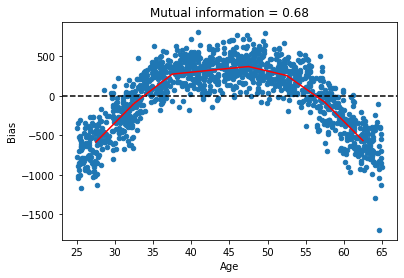

In [9]:
def plot_age_bias(biases, name):
    mutual_info = mutual_info_regression(biases[['Age']], biases[name])[0]
    ax = biases.plot(x='Age', y=name, kind='scatter', title=f'Mutual information = {mutual_info:.2f}')
    ax.axhline(0, c='k', ls='--')
    biases.assign(Age = lambda df: df['Age']//5 * 5 + 2.5).groupby('Age')[name].mean().plot(ax=ax, c='r')
    plt.ylabel('Bias')
    return ax

plot_age_bias(biases, 'BiasNaive')
plt.show()

We clearly see the model is biased, with an advantage that middle-aged people have over both younger and older colleauges. This worries me a lot. One of the drivers of data science in the last few years is the enormous growth of volume of data, which allows us to easily fit complex, non-parametric models which pick up all sorts of correlations and non-linearities which lead to good performance. And then when it comes to fairness, a lot of proposed strategies can even fail to detect a simple quadratic dependency.

## The choice for approaches for regression is much smaller than for classification
While it is generally true in Data Science nowadays that regression is somewhat neglected, with classificatoin models coming from a much richer environment, this holds for fairness in regression problems too, unfortunately. Bias mitigation strategies can be classified as either during _preprocessing_, _inprocessing_ or _postprocessing_ (see Part 1 for a deeper explanation) and what we mainly see is that we can use the preprocessing algorithms that work for classificatoin as well, that inprocessing algorithms work only if the sensitive column is categorical (which is not our case here, and, as I have shown, we should not discretize) and postprocessing algorithms are not applicable for regression; so how to mitigate the bias is much more one-sided.

I looked into three packages and count the number of bias mitigation strategies for classification and regression problems, as of June 17, 2021.
* [`aif360`](https://aif360.readthedocs.io/en/latest/modules/sklearn.html#) has in its scikit-learn compatible API: 
  * 1 preprocessor, but it is not applicable for regression, 
  * Only 1 of 3 inprocessors work for regression, but only for categorical sensitive features (so still not applicable in our case) 
  * Its postprocessor does not work for regression
* [`sklego`](https://scikit-lego.readthedocs.io/en/latest/fairness.html#)
   * 1 preprocessor, that can be used for regression
   * None of its 2 inprocessors work for regression
* [`fairlearn`](https://fairlearn.org/v0.6.2/user_guide/mitigation.html)
  * 1 preprocessor, that can also be used, 
  * Its inprocessors work for regression, but only for categorical sensitive features (we have a continuous sensitive feature here) 
  * Its postprocessor does not work for regression

In conclusion, from the existing packages I looked at, I can only use preprocessing as a bias mitigation strategy.

The `IgnoringBiasEstimator` adds an inprocessing bias mitigation strategy, adding to a richer variety of strategies for Data Scientist to choose from.

## Many approaches fail to deal with non-linear biases
Let's quickly implement the preprocessing techniques from the two packages that are still alive: `scikit-lego` and `fairlearn`. Unfortunately, both turn out not to remove the bias fully.

### `scikit-lego`: InformationFilter
`scikit-lego` implements an [approach](https://scikit-lego.readthedocs.io/en/latest/fairness.html) where the data is transformed through an "InformationFilter" using a [Gram-Schmidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) so that the remaining dataset should not correlate with the sensitive attributes anymore. Let's see how that works out.

In [10]:
clf_information_filter = make_pipeline(sklego.preprocessing.InformationFilter(['Age']),
                                       RandomForestRegressor(**rf_kwargs),
                                      )

In [11]:
clf_information_filter.fit(X_train, y_train)
y_pred_inf = utils.predict_series(clf_information_filter, X=X_test)
biases['BiasInformationFilter'] = y_pred_inf.sub(y_skill_test)

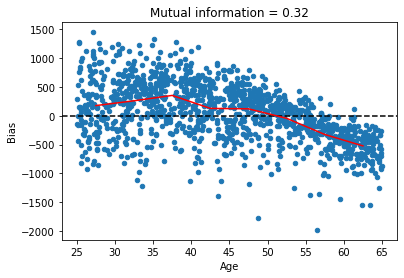

In [12]:
plot_age_bias(biases, 'BiasInformationFilter')
plt.show()

While the bias is less than it was, it's not removed at all.

### `fairlearn`: CorrelationRemover
Already of `fairlearn`s [CorrelationRemover](https://fairlearn.org/v0.6.2/api_reference/fairlearn.preprocessing.html) is a bit worrisom in that it mentions a "linear transformation" and expecting it to be "most appropriate for linear models", but since we do not have much else to go, let's go ahead

In [13]:
clf_correlation_remover = make_pipeline(fairlearn.preprocessing.CorrelationRemover(sensitive_feature_ids=['Age']),
                                        RandomForestRegressor(**rf_kwargs),
                                       )

In [14]:
clf_correlation_remover.fit(X_train, y_train)
y_pred_correm = utils.predict_series(clf_correlation_remover, X=X_test)
biases['CorrelationRemover'] = y_pred_correm.sub(y_skill_test)

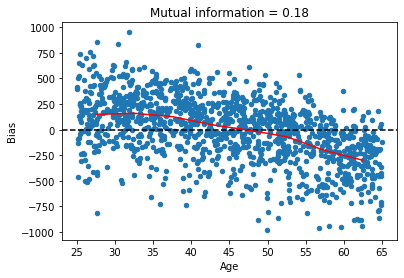

In [15]:
plot_age_bias(biases, 'CorrelationRemover')
plt.show()

Again there is a lot of bias left, because the bias is quadratic and not linear.

## A better approach: The IgnoringEstimator solves non-linear problem out-of-the-box.

Luckily, this doesn't even have to be hard. 

Here again we can use the IgnoringEstimator, which learns the non-linear bias but does not use it at prediction. Additionally, we specify a `correction_strategy`: by default the model imputes the mean value for senstive columns, but in our case, the mean age has a positive bias which would lead to generally overestimated salaries. By specifying a correction strategy, the model subtracts the mean overprediction from each prediction to compensate for this. Other correction strategies are also implemented.

In [16]:
ib = fairestimator.IgnoringBiasRegressor(RandomForestRegressor(**rf_kwargs),
                                         ignored_cols=[0], # Ignore the zeroeth column at prediction time -> Age
                                         correction_strategy='Additive') 
ib.fit(X_train, y_train)

In [17]:
y_pred_ic = utils.predict_series(ib, X=X_test)
y_bias_ic = y_pred_ic.sub(y_skill_test).rename('BiasIC')
biases['IgnoringBias'] = y_bias_ic

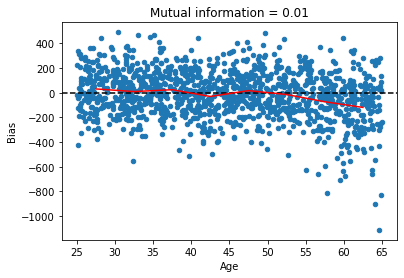

In [18]:
plot_age_bias(biases, 'IgnoringBias')
plt.show()

And with almost no effort, there is basically nothing left of the bias.

## Conclusion and outlook

In this installment, I showed that bias can be a complex function of features, but that the many current existing strategies are not equipped to deal with that, especially when it comes to regression targets. Importantly, I showed that the IgnoringBias estimator does so, and does so out-of-the-box with no tweaking necessary.

In the final installment, I will investigate how the estimator works for a classification problem, which will also allow for a more comprehensive comparison with other bias mitigation strategies, since more classification bias mitigation strategies exist.